### Denoising Autoencoders And Where To Find Them

Today we're going to train deep autoencoders and deploy them to faces and search for similar images.

Our new test subjects are human faces from the [lfw dataset](http://vis-www.cs.umass.edu/lfw/).

In [1]:
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall19/week08_autoencoders/lfw_dataset.py -O lfw_dataset.py
!pip install scikit-learn==0.20.0
!pip install Image Pillow scipy

import torch
import numpy as np

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim



EPOCHS = 100
BATCH_SIZE = 32
LEARNING_RATE = 1e-3

LATENT_DIMENSION = 4


device = torch.device("cuda") # or you print here you favorite gpu card
#torch.set_default_tensor_type(torch.cuda.FloatTensor) 
# uses cuda floats by default
print(device)

--2020-03-21 12:43:35--  https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall19/week08_autoencoders/lfw_dataset.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3060 (3.0K) [text/plain]
Saving to: ‘lfw_dataset.py’

lfw_dataset.py      100%[===================>]   2.99K  --.-KB/s    in 0s      

2020-03-21 12:43:35 (72.8 MB/s) - ‘lfw_dataset.py’ saved [3060/3060]

cuda


In [0]:
BATCH_SIZE = 32

In [0]:
import numpy as np
from lfw_dataset import fetch_lfw_dataset
from sklearn.model_selection import train_test_split
X, attr = fetch_lfw_dataset(use_raw=True,dimx=38,dimy=38)
X = X.transpose([0,3,1,2]).astype('float32') / 256.0

img_shape = X.shape[1:]

X_train, X_test = train_test_split(X, test_size=0.1,random_state=42)

In [0]:
X_train_tensor = torch.from_numpy(X_train).type(torch.DoubleTensor)
X_test_tensor = torch.Tensor(X_test).type(torch.DoubleTensor)

In [5]:
img_shape

(3, 38, 38)

X shape: (13143, 3, 38, 38)
attr shape: (13143, 73)


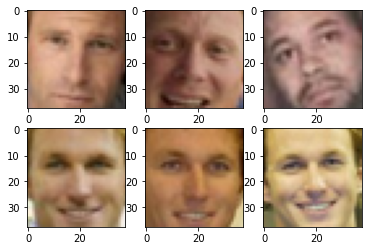

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.title('sample image')
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(X[i].transpose([1,2,0]))

print("X shape:",X.shape)
print("attr shape:",attr.shape)

### Autoencoder architecture

Let's design autoencoder as a single lasagne network, going from input image through bottleneck into the reconstructed image.

<img src="http://nghiaho.com/wp-content/uploads/2012/12/autoencoder_network1.png" width=640px>



## First step: PCA

Principial Component Analysis is a popular dimensionality reduction method. 

Under the hood, PCA attempts to decompose object-feature matrix $X$ into two smaller matrices: $W$ and $\hat W$ minimizing _mean squared error_:

$$\|(X W) \hat{W} - X\|^2_2 \to_{W, \hat{W}} \min$$
- $X \in \mathbb{R}^{n \times m}$ - object matrix (**centered**);
- $W \in \mathbb{R}^{m \times d}$ - matrix of direct transformation;
- $\hat{W} \in \mathbb{R}^{d \times m}$ - matrix of reverse transformation;
- $n$ samples, $m$ original dimensions and $d$ target dimensions;

In geometric terms, we want to find d axes along which most of variance occurs. The "natural" axes, if you wish.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/9/90/PCA_fish.png/256px-PCA_fish.png)


PCA can also be seen as a special case of an autoencoder.

* __Encoder__: X -> Dense(d units) -> code
* __Decoder__: code -> Dense(m units) -> X

Where Dense is a fully-connected layer with linear activaton:   $f(X) = W \cdot X + \vec b $


Note: the bias term in those layers is responsible for "centering" the matrix i.e. substracting mean.

In [0]:
# this class corresponds to view-function and may be used as a reshape layer 

class View(nn.Module):
    def __init__(self, *shape):
        super(View, self).__init__()
        self.shape = shape
    def forward(self, input):
        return input.view(*self.shape)

In [0]:
class pca_autoencoder(nn.Module):
    """
    Here we define a simple linear autoencoder as described above.
    We also flatten and un-flatten data to be compatible with image shapes
    """
    
    def __init__(self, code_size=32):
        super(pca_autoencoder, self).__init__()
        self.enc = nn.Sequential(View(-1, np.prod(img_shape)), nn.Linear(np.prod(img_shape), code_size))
        self.dec = nn.Sequential(nn.Linear(code_size, np.prod(img_shape)), View(-1, img_shape[0], img_shape[1], img_shape[2])) 
    
    def batch_loss(self, batch, reference):
        reconstruction = self.dec(self.enc(batch))
        return torch.mean((reference - reconstruction)**2)
    

### Train the model

As usual, iterate minibatches of data and call train_step, then evaluate loss on validation data.

__Note to py2 users:__ you can safely drop `flush=True` from any code below.

In [0]:
from tqdm import tqdm
def train(model, dataset, dataset_test, num_epoch=32, gd=None, noise_function=None, noise_function_params=None):
    model.double()
    model.to(device)
    if gd is None:
        gd = optim.Adamax(model.parameters(), lr=0.002)
    if noise_function_params is None:
        noise_function_params = {}
    
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    losses = []
    dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True)
    scores = []

    for epoch in range(num_epoch):
        model.train(True)
        for i, (batch) in tqdm(enumerate(dataloader)):
            gd.zero_grad()
            if noise_function is not None:
                batch_noised = noise_function(batch, **noise_function_params).to(device=device)
                loss = model.batch_loss(batch_noised, batch.to(device=device))
            else:
                batch = batch.to(device=device)
                loss = model.batch_loss(batch, batch)
            (loss).backward()
            losses.append(loss.data.cpu().numpy())
            gd.step()
            gd.zero_grad()
        train_mse = np.mean(losses[-(i+1):])
        
        model.train(False)
        for i, (batch) in enumerate(dataloader_test):
            batch = batch.to(device=device)
            scores.append(model.batch_loss(batch, batch).data.cpu().numpy())
        test_mse  = np.mean(scores[-(i+1):])

        print(f"{epoch+1}, Train loss: {train_mse}, Test loss: {test_mse}")

In [0]:
def visualize(img, model):
    """Draws original, encoded and decoded images"""
    model.train(False)
    code = model.enc(img[None].cuda(device = device))

    reco = model.dec(code)

    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(img.cpu().numpy().transpose([1, 2, 0]).clip(0, 1))

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.cpu().detach().numpy().reshape([code.shape[-1] // 2, -1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    plt.imshow(reco[0].cpu().detach().numpy().transpose([1, 2, 0]).clip(0, 1))
    plt.show()


In [0]:
aenc = pca_autoencoder()
train(aenc, X_train_tensor, X_test_tensor, 40)

In [11]:
dataloader_test = DataLoader(X_test_tensor, batch_size=BATCH_SIZE, shuffle=True)
scores = []
for i, (batch) in enumerate(dataloader_test):
    batch = batch.to(device=device)
    scores.append(aenc.batch_loss(batch, batch).data.cpu().numpy())
print (np.mean(scores))

NameError: ignored

In [0]:
for i in range(5):
    img = X_test_tensor[i]
    visualize(img,aenc)


### Going deeper

PCA is neat but surely we can do better. This time we want you to build a deep autoencoder by... stacking more layers.

In particular, your encoder and decoder should be at least 3 layers deep each. You can use any nonlinearity you want and any number of hidden units in non-bottleneck layers provided you can actually afford training it.

![layers](https://pbs.twimg.com/media/CYggEo-VAAACg_n.png:small)

A few sanity checks:
* There shouldn't be any hidden layer smaller than bottleneck (encoder output).
* Don't forget to insert nonlinearities between intermediate dense layers.
* Convolutional layers are allowed but not required. To undo convolution use L.Deconv2D, pooling - L.UpSampling2D.
* Adding activation after bottleneck is allowed, but not strictly necessary.

In [0]:
class pca_autoencoder_deep(nn.Module):
    def __init__(self, code_size=32):
        super(pca_autoencoder_deep, self).__init__()
        self.enc = nn.Sequential(
            View(-1, np.prod(img_shape)),
            nn.Linear(np.prod(img_shape), code_size*16),
            nn.BatchNorm1d(code_size*16),
            nn.LeakyReLU(),
            nn.Linear(code_size*16, code_size*4),
            nn.BatchNorm1d(code_size*4),
            nn.LeakyReLU(),
            nn.Linear(code_size*4, code_size),
            nn.Tanh())
    
        self.dec = nn.Sequential(
            nn.Linear(code_size, code_size*4),
            nn.BatchNorm1d(code_size*4),
            nn.LeakyReLU(),
            nn.Linear(code_size*4, code_size*16),
            nn.BatchNorm1d(code_size*16),
            nn.LeakyReLU(),
            nn.Linear(code_size*16, np.prod(img_shape)),
            View(-1, img_shape[0], img_shape[1], img_shape[2])) 
    
    def batch_loss(self, batch, reference):
        a = self.enc(batch)
        reconstruction = self.dec(a)
        return torch.mean((reference - reconstruction)**2)

In [101]:
#Check autoencoder shapes along different code_sizes
get_dim = lambda layer: np.prod(layer.output_shape[1:])
for code_size in [1,8,32,128,512,1024]:
    help_tensor = next(iter(DataLoader(X_train_tensor, batch_size=BATCH_SIZE)))
    model = pca_autoencoder_deep(code_size).double().to(device)
    encoder_out = model.enc(help_tensor.cuda(device))
    decoder_out = model.dec(encoder_out)
    print("Testing code size %i" % code_size)

    assert encoder_out.shape[1:]==torch.Size([code_size]),"encoder must output a code of required size"
    assert decoder_out.shape[1:]==img_shape,   "decoder must output an image of valid shape"

    assert (sum([1 + len(list(c1level.children())) for c1level in model.dec.children()]) >= 6),  "decoder must contain at least 3 dense layers"

    del encoder_out
    del decoder_out
    torch.cuda.empty_cache()
print("All tests passed!")

Testing code size 1
Testing code size 8
Testing code size 32
Testing code size 128
Testing code size 512
Testing code size 1024
All tests passed!


__Hint:__ if you're getting "Encoder layer is smaller than bottleneck" error, use code_size when defining intermediate layers. 

For example, such layer may have code_size*2 units.

In [102]:
aenc_deep = pca_autoencoder_deep()
train(aenc_deep, X_train_tensor, X_test_tensor, 100)

370it [00:03, 101.34it/s]
11it [00:00, 103.71it/s]

1, Train loss: 0.023164623712336053, Test loss: 0.014839073908136532


370it [00:03, 101.10it/s]
11it [00:00, 102.16it/s]

2, Train loss: 0.015359671126189267, Test loss: 0.013373660945576288


370it [00:03, 101.87it/s]
10it [00:00, 97.42it/s]

3, Train loss: 0.014166264495230988, Test loss: 0.012273899520426804


370it [00:03, 101.74it/s]
10it [00:00, 99.99it/s]

4, Train loss: 0.013463762637911996, Test loss: 0.012073452734423142


370it [00:03, 101.37it/s]
11it [00:00, 102.83it/s]

5, Train loss: 0.01281101759277223, Test loss: 0.011485791080590491


370it [00:03, 101.36it/s]
11it [00:00, 101.01it/s]

6, Train loss: 0.012434323469574607, Test loss: 0.01099861189395546


370it [00:03, 101.83it/s]
10it [00:00, 99.80it/s]

7, Train loss: 0.01201183725107741, Test loss: 0.01087545451209155


370it [00:03, 99.91it/s] 
10it [00:00, 98.78it/s]

8, Train loss: 0.011578050220198083, Test loss: 0.010001429929559583


370it [00:03, 99.14it/s] 
11it [00:00, 103.80it/s]

9, Train loss: 0.011244900614057609, Test loss: 0.01031064499053601


370it [00:03, 100.54it/s]
11it [00:00, 103.14it/s]

10, Train loss: 0.010894187991763326, Test loss: 0.009985618041188716


370it [00:03, 100.11it/s]
11it [00:00, 102.66it/s]

11, Train loss: 0.01050316194958946, Test loss: 0.009849157769330253


370it [00:03, 100.19it/s]
11it [00:00, 102.10it/s]

12, Train loss: 0.01025230611383114, Test loss: 0.00940403273195866


370it [00:03, 100.48it/s]
10it [00:00, 100.00it/s]

13, Train loss: 0.010119736316635932, Test loss: 0.009743204424518492


370it [00:03, 99.62it/s] 
11it [00:00, 103.60it/s]

14, Train loss: 0.009883612641967833, Test loss: 0.008608759283033897


370it [00:03, 99.94it/s]
11it [00:00, 103.58it/s]

15, Train loss: 0.00970233262576118, Test loss: 0.008677411248198786


370it [00:03, 99.93it/s]
11it [00:00, 103.83it/s]

16, Train loss: 0.009546786698310848, Test loss: 0.008742176043378526


370it [00:03, 100.15it/s]
11it [00:00, 102.66it/s]

17, Train loss: 0.009348463258748116, Test loss: 0.008508031720303963


370it [00:03, 100.72it/s]
11it [00:00, 101.59it/s]

18, Train loss: 0.009343484223369945, Test loss: 0.008384898935106827


370it [00:03, 101.33it/s]
11it [00:00, 103.03it/s]

19, Train loss: 0.009096356897755481, Test loss: 0.00824144360250225


370it [00:03, 101.18it/s]
11it [00:00, 102.74it/s]

20, Train loss: 0.008927849360460774, Test loss: 0.007844308019672726


370it [00:03, 101.20it/s]
11it [00:00, 103.23it/s]

21, Train loss: 0.008819705676504998, Test loss: 0.008069356473885488


370it [00:03, 100.44it/s]
11it [00:00, 101.07it/s]

22, Train loss: 0.00866815877565161, Test loss: 0.008334562728449926


370it [00:03, 100.49it/s]
11it [00:00, 99.70it/s]

23, Train loss: 0.00864880887897361, Test loss: 0.007774253017794689


370it [00:03, 100.18it/s]
11it [00:00, 101.53it/s]

24, Train loss: 0.00857223407811083, Test loss: 0.008399175127123666


370it [00:03, 100.06it/s]
11it [00:00, 101.99it/s]

25, Train loss: 0.008426701405533593, Test loss: 0.007957340650527858


370it [00:03, 100.30it/s]
11it [00:00, 102.71it/s]

26, Train loss: 0.008348002425566972, Test loss: 0.007621762083443255


370it [00:03, 100.85it/s]
11it [00:00, 102.60it/s]

27, Train loss: 0.008220974791496, Test loss: 0.007591112500400343


370it [00:03, 101.27it/s]
11it [00:00, 104.31it/s]

28, Train loss: 0.008199790225612971, Test loss: 0.00796993822719251


370it [00:03, 101.64it/s]
11it [00:00, 101.11it/s]

29, Train loss: 0.008124340975148225, Test loss: 0.007480984211614656


370it [00:03, 101.24it/s]
11it [00:00, 102.95it/s]

30, Train loss: 0.008075246000473567, Test loss: 0.007725348097799849


370it [00:03, 101.09it/s]
10it [00:00, 98.45it/s]

31, Train loss: 0.008000326045772848, Test loss: 0.007543305291474771


370it [00:03, 100.39it/s]
11it [00:00, 104.24it/s]

32, Train loss: 0.007943748607898671, Test loss: 0.007725339920310677


370it [00:03, 100.52it/s]
11it [00:00, 100.28it/s]

33, Train loss: 0.007929147440934026, Test loss: 0.007592647409880458


370it [00:03, 100.39it/s]
10it [00:00, 99.68it/s]

34, Train loss: 0.007870162065253079, Test loss: 0.0072535490851529105


370it [00:03, 100.54it/s]
11it [00:00, 102.63it/s]

35, Train loss: 0.00781522513149867, Test loss: 0.007182806744335466


370it [00:03, 99.91it/s]
11it [00:00, 100.91it/s]

36, Train loss: 0.007706400202974826, Test loss: 0.007145866557056152


370it [00:03, 100.27it/s]
11it [00:00, 102.39it/s]

37, Train loss: 0.0077046690193528135, Test loss: 0.007276178241264586


370it [00:03, 100.45it/s]
11it [00:00, 101.19it/s]

38, Train loss: 0.007705976229528227, Test loss: 0.007047334486159293


370it [00:03, 100.18it/s]
11it [00:00, 102.16it/s]

39, Train loss: 0.007680758448129141, Test loss: 0.007180828173974194


370it [00:03, 100.32it/s]
11it [00:00, 102.28it/s]

40, Train loss: 0.0076208126787821, Test loss: 0.007422261969254342


370it [00:03, 100.39it/s]
11it [00:00, 103.56it/s]

41, Train loss: 0.007605798330150822, Test loss: 0.007214833044012282


370it [00:03, 100.63it/s]
11it [00:00, 100.89it/s]

42, Train loss: 0.0075664797307302915, Test loss: 0.00721039896129887


370it [00:03, 100.66it/s]
10it [00:00, 92.65it/s]

43, Train loss: 0.007566580386977182, Test loss: 0.007184043272362518


370it [00:03, 100.96it/s]
11it [00:00, 104.13it/s]

44, Train loss: 0.007516192854752588, Test loss: 0.006979132476692539


370it [00:03, 100.98it/s]
10it [00:00, 99.26it/s]

45, Train loss: 0.007480553011381072, Test loss: 0.0070580367543119915


370it [00:03, 100.57it/s]
11it [00:00, 101.86it/s]

46, Train loss: 0.0074201218373664566, Test loss: 0.006795731100621135


370it [00:03, 100.16it/s]
11it [00:00, 103.06it/s]

47, Train loss: 0.0073635316965972464, Test loss: 0.0068645884460914585


370it [00:03, 101.18it/s]
11it [00:00, 100.81it/s]

48, Train loss: 0.007375654630093579, Test loss: 0.006945837954751542


370it [00:03, 100.75it/s]
11it [00:00, 103.41it/s]

49, Train loss: 0.007359618075456783, Test loss: 0.006896560417714298


370it [00:03, 100.97it/s]
11it [00:00, 102.56it/s]

50, Train loss: 0.007328855917924918, Test loss: 0.0070071703895166525


370it [00:03, 100.20it/s]
11it [00:00, 103.54it/s]

51, Train loss: 0.007369043176594087, Test loss: 0.006950720862961451


370it [00:03, 99.79it/s] 
11it [00:00, 100.67it/s]

52, Train loss: 0.007333741243436274, Test loss: 0.006845970056283396


370it [00:03, 100.41it/s]
10it [00:00, 99.46it/s]

53, Train loss: 0.007242699570726755, Test loss: 0.006907726794376229


370it [00:03, 100.73it/s]
11it [00:00, 101.59it/s]

54, Train loss: 0.0072286308205053865, Test loss: 0.007180197953105859


370it [00:03, 99.39it/s]
11it [00:00, 103.66it/s]

55, Train loss: 0.007293101040120452, Test loss: 0.006885214999512993


370it [00:03, 98.54it/s]
11it [00:00, 102.06it/s]

56, Train loss: 0.007263005567698052, Test loss: 0.007057874883650402


370it [00:03, 99.58it/s]
11it [00:00, 103.32it/s]

57, Train loss: 0.007258039349034221, Test loss: 0.00687488346401789


370it [00:03, 100.80it/s]
10it [00:00, 99.80it/s]

58, Train loss: 0.0071531682615258415, Test loss: 0.006843016641726752


370it [00:03, 100.24it/s]
11it [00:00, 102.18it/s]

59, Train loss: 0.007211101724685365, Test loss: 0.006862651575921598


370it [00:03, 100.64it/s]
10it [00:00, 98.41it/s]

60, Train loss: 0.007086810769040432, Test loss: 0.006824024311905127


370it [00:03, 100.26it/s]
11it [00:00, 101.53it/s]

61, Train loss: 0.007138766459078618, Test loss: 0.006695143297196158


370it [00:03, 100.75it/s]
11it [00:00, 101.29it/s]

62, Train loss: 0.007093976213659502, Test loss: 0.00692414951744756


370it [00:03, 100.03it/s]
11it [00:00, 102.48it/s]

63, Train loss: 0.007107333847595903, Test loss: 0.006973949427464217


370it [00:03, 100.86it/s]
10it [00:00, 99.22it/s]

64, Train loss: 0.007118983114281678, Test loss: 0.0069711002229894


370it [00:03, 100.32it/s]
11it [00:00, 101.37it/s]

65, Train loss: 0.007006601775929316, Test loss: 0.006721578113415265


370it [00:03, 100.44it/s]
11it [00:00, 103.38it/s]

66, Train loss: 0.007011480099842942, Test loss: 0.006772718393548447


370it [00:03, 100.96it/s]
11it [00:00, 99.92it/s]

67, Train loss: 0.00702132082858007, Test loss: 0.006964429825005175


370it [00:03, 100.23it/s]
11it [00:00, 100.79it/s]

68, Train loss: 0.007016773250618391, Test loss: 0.007007477189827289


370it [00:03, 100.92it/s]
11it [00:00, 100.30it/s]

69, Train loss: 0.007008710710745598, Test loss: 0.006776514739312675


370it [00:03, 100.50it/s]
10it [00:00, 98.70it/s]

70, Train loss: 0.006946193621251072, Test loss: 0.006837605930285265


370it [00:03, 100.31it/s]
11it [00:00, 103.23it/s]

71, Train loss: 0.006946333194616421, Test loss: 0.006552697250175309


370it [00:03, 101.00it/s]
11it [00:00, 104.20it/s]

72, Train loss: 0.006932393765369857, Test loss: 0.006831085868600072


370it [00:03, 101.45it/s]
11it [00:00, 103.68it/s]

73, Train loss: 0.006935626928925658, Test loss: 0.006589787471431395


370it [00:03, 100.56it/s]
11it [00:00, 102.29it/s]

74, Train loss: 0.0069222230061310895, Test loss: 0.006762547299018368


370it [00:03, 101.09it/s]
11it [00:00, 103.14it/s]

75, Train loss: 0.006949638593659695, Test loss: 0.006687134901464081


370it [00:03, 101.10it/s]
11it [00:00, 102.71it/s]

76, Train loss: 0.006847590843193348, Test loss: 0.0065777490499661665


370it [00:03, 100.70it/s]
11it [00:00, 102.22it/s]

77, Train loss: 0.006899850656579028, Test loss: 0.006692415224311433


370it [00:03, 101.12it/s]
11it [00:00, 102.58it/s]

78, Train loss: 0.006904527680148446, Test loss: 0.006592626032110865


370it [00:03, 100.72it/s]
11it [00:00, 101.65it/s]

79, Train loss: 0.006888394415347309, Test loss: 0.0067036148229143045


370it [00:03, 100.61it/s]
11it [00:00, 99.32it/s]

80, Train loss: 0.006874417777918067, Test loss: 0.007113386227688183


370it [00:03, 101.12it/s]
11it [00:00, 102.20it/s]

81, Train loss: 0.00687487674728912, Test loss: 0.0069864194409357695


370it [00:03, 100.79it/s]
11it [00:00, 102.48it/s]

82, Train loss: 0.006898973071577901, Test loss: 0.006816803659513497


370it [00:03, 101.21it/s]
11it [00:00, 101.33it/s]

83, Train loss: 0.006879923716331801, Test loss: 0.0067400173437502375


370it [00:03, 100.89it/s]
11it [00:00, 102.52it/s]

84, Train loss: 0.006823935234566517, Test loss: 0.006798775568740292


370it [00:03, 100.19it/s]
11it [00:00, 101.14it/s]

85, Train loss: 0.006886607738593258, Test loss: 0.006681042374189676


370it [00:03, 101.78it/s]
11it [00:00, 103.95it/s]

86, Train loss: 0.006818831596179915, Test loss: 0.006746781107468294


370it [00:03, 100.65it/s]
11it [00:00, 103.48it/s]

87, Train loss: 0.00683200150623802, Test loss: 0.006550419321086058


370it [00:03, 100.33it/s]
11it [00:00, 104.56it/s]

88, Train loss: 0.006763615063045683, Test loss: 0.00661649150778802


370it [00:03, 100.65it/s]
11it [00:00, 100.47it/s]

89, Train loss: 0.0068049225162456015, Test loss: 0.006532745462401603


370it [00:03, 100.26it/s]
11it [00:00, 102.54it/s]

90, Train loss: 0.00676713770638739, Test loss: 0.006628678519466342


370it [00:03, 101.03it/s]
11it [00:00, 101.29it/s]

91, Train loss: 0.006773034087474053, Test loss: 0.006594629758035716


370it [00:03, 100.73it/s]
11it [00:00, 102.47it/s]

92, Train loss: 0.006769083097611017, Test loss: 0.006621677525054059


370it [00:03, 101.26it/s]
11it [00:00, 101.42it/s]

93, Train loss: 0.006747569581296098, Test loss: 0.0066485621597148475


370it [00:03, 101.51it/s]
11it [00:00, 103.40it/s]

94, Train loss: 0.006710172046208068, Test loss: 0.006583307393768548


370it [00:03, 100.52it/s]
11it [00:00, 104.69it/s]

95, Train loss: 0.006737330642241958, Test loss: 0.0066424393842189925


370it [00:03, 100.82it/s]
10it [00:00, 98.63it/s]

96, Train loss: 0.00670902894133713, Test loss: 0.006551403171039259


370it [00:03, 101.84it/s]
11it [00:00, 104.07it/s]

97, Train loss: 0.006739658040686823, Test loss: 0.006528276268420167


370it [00:03, 101.69it/s]
11it [00:00, 101.76it/s]

98, Train loss: 0.0066540460987132375, Test loss: 0.00645740672138512


370it [00:03, 101.34it/s]
10it [00:00, 99.59it/s]

99, Train loss: 0.006716634231435596, Test loss: 0.006682040560018246


370it [00:03, 101.21it/s]


100, Train loss: 0.006692235017574646, Test loss: 0.006605339372170918


Training may take long, it's okay.

Final MSE: 0.006989806351306902


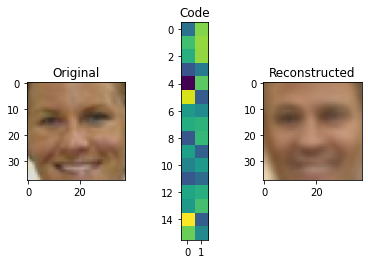

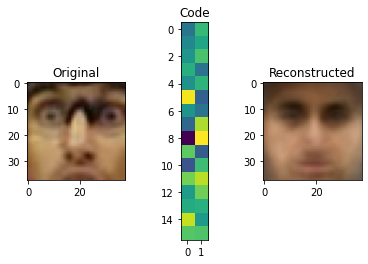

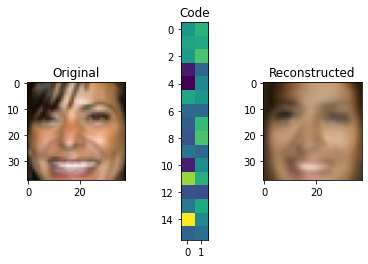

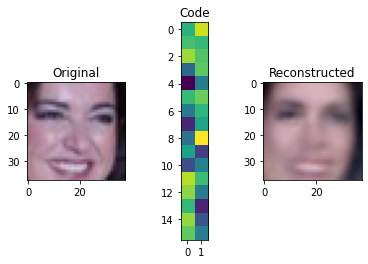

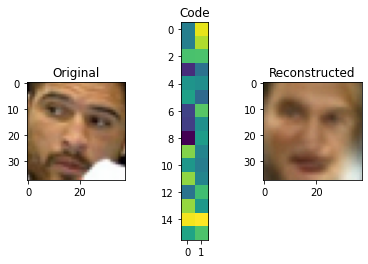

In [78]:
aenc_deep.train(False)
dataloader_test = DataLoader(X_test_tensor, batch_size=BATCH_SIZE, shuffle=True)
scores = []
for i, (batch) in enumerate(dataloader_test):
    batch = batch.to(device=device)
    scores.append(aenc_deep.batch_loss(batch, batch).data.cpu().numpy())
    encoder_out = aenc_deep.enc(batch)
reconstruction_mse  = np.mean(scores)

# assert reconstruction_mse <= 0.0055, "Compression is too lossy. See tips below."
# assert len(encoder_out.shape)==2 and encoder_out.shape[1]==32, "Make sure encoder has code_size units"
print("Final MSE:", reconstruction_mse)
for i in range(5):
    img = X_test_tensor[i]
    visualize(img,aenc_deep)

__Tips:__ If you keep getting "Compression to lossy" error, there's a few things you might try:

* Make sure it converged. Some architectures need way more than 32 epochs to converge. They may fluctuate a lot, but eventually they're going to get good enough to pass. You may train your network for as long as you want.

* Complexity. If you already have, like, 152 layers and still not passing threshold, you may wish to start from something simpler instead and go in small incremental steps.

* Architecture. You can use any combination of layers (including convolutions, normalization, etc) as long as __encoder output only stores 32 numbers per training object__. 

A cunning learner can circumvent this last limitation by using some manual encoding strategy, but he is strongly recommended to avoid that.

## Denoising AutoEncoder

Let's now make our model into a denoising autoencoder.

We'll keep your model architecture, but change the way it trains. In particular, we'll corrupt it's input data randomly before each epoch.

There are many strategies to apply noise. We'll implement two popular one: adding gaussian noise and using dropout.

In [0]:
def apply_gaussian_noise(X,sigma=0.1):
    """
    adds noise from normal distribution with standard deviation sigma
    :param X: image tensor of shape [batch,height,width,3]
    """
    noise = torch.randn(X.size()) * sigma
    return X + noise
    

In [0]:
#noise tests
theoretical_std = (X[:100].std()**2 + 0.5**2)**.5
our_std = apply_gaussian_noise(torch.from_numpy(X[:100]),sigma=0.5).std()
assert abs(theoretical_std - our_std) < 0.01, "Standard deviation does not match it's required value. Make sure you use sigma as std."
assert abs(apply_gaussian_noise(torch.from_numpy(X[:100]),sigma=0.5).mean() - torch.from_numpy(X[:100]).mean()) < 0.01, "Mean has changed. Please add zero-mean noise"

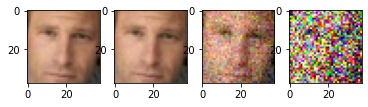

In [16]:
plt.subplot(1,4,1)
plt.imshow(X[0].transpose([1,2,0]))
plt.subplot(1,4,2)
plt.imshow(apply_gaussian_noise(torch.from_numpy(X[:1]),sigma=0.01).data.numpy()[0].transpose([1,2,0]).clip(0, 1))
plt.subplot(1,4,3)
plt.imshow(apply_gaussian_noise(torch.from_numpy(X[:1]),sigma=0.1).data.numpy()[0].transpose([1,2,0]).clip(0, 1))
plt.subplot(1,4,4)
plt.imshow(apply_gaussian_noise(torch.from_numpy(X[:1]),sigma=0.5).data.numpy()[0].transpose([1,2,0]).clip(0, 1))

In [17]:
aenc = pca_autoencoder()
train(aenc, X_train_tensor, X_test_tensor, 50, noise_function=apply_gaussian_noise)

370it [00:01, 190.51it/s]
20it [00:00, 196.17it/s]

1, Train loss: 0.15059797139416786, Test loss: 0.03159717392875677


370it [00:01, 195.12it/s]
19it [00:00, 184.12it/s]

2, Train loss: 0.026280381956891464, Test loss: 0.022830507097352508


370it [00:01, 191.52it/s]
18it [00:00, 172.15it/s]

3, Train loss: 0.0235472145870305, Test loss: 0.022422745231275947


370it [00:01, 193.29it/s]
20it [00:00, 198.86it/s]

4, Train loss: 0.02324222787639751, Test loss: 0.022439418992208724


370it [00:01, 194.08it/s]
19it [00:00, 189.14it/s]

5, Train loss: 0.02302041909184244, Test loss: 0.022052337201470387


370it [00:01, 192.71it/s]
21it [00:00, 203.45it/s]

6, Train loss: 0.022735856659325534, Test loss: 0.021885917699982962


370it [00:01, 192.33it/s]
21it [00:00, 200.83it/s]

7, Train loss: 0.02229985126874624, Test loss: 0.021422193849191012


370it [00:01, 191.77it/s]
20it [00:00, 192.94it/s]

8, Train loss: 0.021422791292436696, Test loss: 0.0205393632808126


370it [00:01, 189.91it/s]
20it [00:00, 195.73it/s]

9, Train loss: 0.020131499400858014, Test loss: 0.019058559618391778


370it [00:01, 193.12it/s]
20it [00:00, 199.75it/s]

10, Train loss: 0.018477697704752678, Test loss: 0.01764438056796197


370it [00:01, 190.96it/s]
20it [00:00, 190.92it/s]

11, Train loss: 0.016617325555853518, Test loss: 0.015598213345609714


370it [00:01, 188.32it/s]
20it [00:00, 197.15it/s]

12, Train loss: 0.015116756526967893, Test loss: 0.014835979455816111


370it [00:01, 191.52it/s]
20it [00:00, 197.44it/s]

13, Train loss: 0.013909576216695023, Test loss: 0.013317048987673344


370it [00:01, 190.59it/s]
20it [00:00, 197.73it/s]

14, Train loss: 0.012773573336199951, Test loss: 0.012232515089728798


370it [00:01, 193.80it/s]
20it [00:00, 199.21it/s]

15, Train loss: 0.011787327371209532, Test loss: 0.011424090496828852


370it [00:01, 192.16it/s]
20it [00:00, 196.34it/s]

16, Train loss: 0.010943588257265886, Test loss: 0.010693085202873107


370it [00:01, 193.28it/s]
19it [00:00, 186.75it/s]

17, Train loss: 0.010268894859511454, Test loss: 0.009861986112057419


370it [00:01, 191.95it/s]
19it [00:00, 184.89it/s]

18, Train loss: 0.009743871434782378, Test loss: 0.00931883407623316


370it [00:01, 192.07it/s]
20it [00:00, 198.45it/s]

19, Train loss: 0.00935321791348929, Test loss: 0.009098956964338033


370it [00:01, 190.47it/s]
20it [00:00, 195.37it/s]

20, Train loss: 0.00899649002748978, Test loss: 0.009374484596581


370it [00:01, 192.53it/s]
18it [00:00, 179.28it/s]

21, Train loss: 0.00867721705777172, Test loss: 0.008929988963725715


370it [00:01, 193.80it/s]
21it [00:00, 204.34it/s]

22, Train loss: 0.008460316309279396, Test loss: 0.008710788079137527


370it [00:01, 193.10it/s]
20it [00:00, 192.77it/s]

23, Train loss: 0.008260284175542526, Test loss: 0.008006238811774175


370it [00:01, 192.85it/s]
20it [00:00, 191.62it/s]

24, Train loss: 0.00804983285987478, Test loss: 0.007876433055756405


370it [00:01, 191.07it/s]
20it [00:00, 198.01it/s]

25, Train loss: 0.007924087102732735, Test loss: 0.007670226864507755


370it [00:01, 191.57it/s]
20it [00:00, 199.53it/s]

26, Train loss: 0.007752100687397302, Test loss: 0.00789740611714833


370it [00:01, 194.65it/s]
19it [00:00, 183.29it/s]

27, Train loss: 0.007568891431623989, Test loss: 0.007832049259149185


370it [00:01, 189.62it/s]
21it [00:00, 209.07it/s]

28, Train loss: 0.007545766929499695, Test loss: 0.007308873224669453


370it [00:01, 193.48it/s]
20it [00:00, 198.66it/s]

29, Train loss: 0.007384840018623405, Test loss: 0.007281925126683674


370it [00:01, 193.62it/s]
21it [00:00, 202.60it/s]

30, Train loss: 0.00739323004461841, Test loss: 0.007282350687300961


370it [00:01, 195.92it/s]
20it [00:00, 195.95it/s]

31, Train loss: 0.007291464667090134, Test loss: 0.007650680761502074


370it [00:01, 195.85it/s]
21it [00:00, 201.22it/s]

32, Train loss: 0.00719441523726167, Test loss: 0.007256608131247659


370it [00:01, 188.69it/s]
18it [00:00, 178.27it/s]

33, Train loss: 0.007101586160374093, Test loss: 0.007080324452705508


370it [00:01, 194.06it/s]
20it [00:00, 199.02it/s]

34, Train loss: 0.0070436824288435205, Test loss: 0.007034621045424602


370it [00:01, 195.25it/s]
18it [00:00, 172.11it/s]

35, Train loss: 0.0069996186816858, Test loss: 0.0069580405006586755


370it [00:01, 192.22it/s]
19it [00:00, 189.41it/s]

36, Train loss: 0.006869724699502404, Test loss: 0.006856944461012798


370it [00:01, 196.60it/s]
21it [00:00, 200.14it/s]

37, Train loss: 0.0068395511183856495, Test loss: 0.006879625744546733


370it [00:01, 196.90it/s]
20it [00:00, 197.36it/s]

38, Train loss: 0.00682307824435523, Test loss: 0.006721575691155688


370it [00:01, 191.02it/s]
21it [00:00, 200.61it/s]

39, Train loss: 0.006709449087895897, Test loss: 0.006740367849811489


370it [00:01, 195.39it/s]
20it [00:00, 197.38it/s]

40, Train loss: 0.0067394423217234595, Test loss: 0.006999486472381363


370it [00:01, 191.19it/s]
19it [00:00, 182.98it/s]

41, Train loss: 0.006674937636641446, Test loss: 0.0067691047425550484


370it [00:01, 187.87it/s]
20it [00:00, 197.86it/s]

42, Train loss: 0.006708557866869103, Test loss: 0.006993391365166882


370it [00:01, 190.91it/s]
19it [00:00, 189.91it/s]

43, Train loss: 0.0066828171476945, Test loss: 0.006999084936506735


370it [00:01, 187.84it/s]
19it [00:00, 187.75it/s]

44, Train loss: 0.006649911578544213, Test loss: 0.00664215353725583


370it [00:01, 191.25it/s]
21it [00:00, 203.44it/s]

45, Train loss: 0.006673493409584743, Test loss: 0.006789827554037432


370it [00:01, 192.19it/s]
20it [00:00, 198.52it/s]

46, Train loss: 0.006629472135077275, Test loss: 0.006590507653371179


370it [00:01, 191.83it/s]
21it [00:00, 206.54it/s]

47, Train loss: 0.0066448068822668556, Test loss: 0.006532641331804269


370it [00:01, 191.92it/s]
19it [00:00, 184.77it/s]

48, Train loss: 0.006593515247484918, Test loss: 0.0066044826665170656


370it [00:01, 185.20it/s]
20it [00:00, 195.84it/s]

49, Train loss: 0.006610722666008708, Test loss: 0.0066722354455401815


370it [00:01, 193.20it/s]


50, Train loss: 0.006610677453406902, Test loss: 0.006897880221663215


__Note:__ if it hasn't yet converged, increase the number of iterations.

__Bonus:__ replace gaussian noise with masking random rectangles on image.

Final MSE: 0.006921935985431512


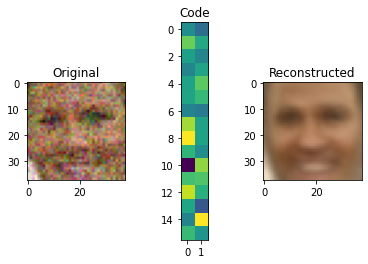

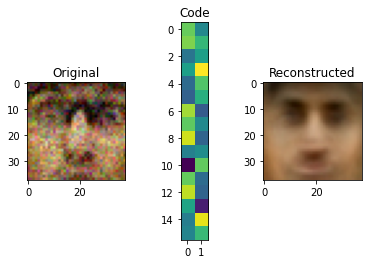

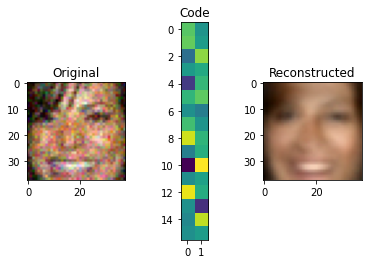

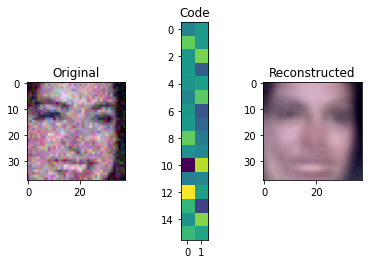

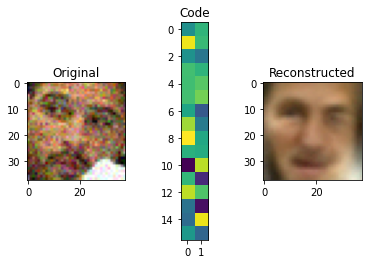

In [18]:
dataloader_test = DataLoader(X_test_tensor, batch_size=BATCH_SIZE, shuffle=True)
scores = []
for i, (batch) in enumerate(dataloader_test):
    batch_noised = apply_gaussian_noise(batch).to(device=device)
    scores.append(aenc.batch_loss(batch_noised, batch.cuda(device = device)).data.cpu().numpy())
    encoder_out = aenc.enc(batch_noised)
reconstruction_mse  = np.mean(scores)

print("Final MSE:", reconstruction_mse)
for i in range(5):
    img = apply_gaussian_noise(X_test_tensor[i])
    visualize(img,aenc)

### Image retrieval with autoencoders

So we've just trained a network that converts image into itself imperfectly. This task is not that useful in and of itself, but it has a number of awesome side-effects. Let's see it in action.

First thing we can do is image retrieval aka image search. We we give it an image and find similar images in latent space. 

To speed up retrieval process, we shall use Locality-Sensitive Hashing on top of encoded vectors. We'll use scikit-learn's implementation for simplicity. In practical scenario, you may want to use [specialized libraries](https://erikbern.com/2015/07/04/benchmark-of-approximate-nearest-neighbor-libraries.html) for better performance and customization.

In [0]:
aenc_old = aenc
aenc = aenc_deep

In [0]:
codes = aenc.enc(X_train_tensor.to(device))

In [107]:
codes[1]

tensor([-0.1640,  0.1059,  0.1152, -0.0347, -0.4160, -0.0221,  0.1271, -0.8693,
         0.0659,  0.2849, -0.0449,  0.1491,  0.7159,  0.2200, -0.1328,  0.2592,
         0.0068,  0.5218,  0.4675,  0.3929, -0.1931,  0.6372, -1.0000,  0.1294,
         0.6281,  0.3297,  0.4820, -0.3302,  0.4066, -0.1877, -0.1911, -0.1555],
       device='cuda:0', dtype=torch.float64, grad_fn=<SelectBackward>)

In [0]:
assert codes.shape[0] == X_train_tensor.shape[0]

In [38]:
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes.detach().cpu().numpy())

/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/approximate.py:258: DeprecationWarning: LSHForest has poor performance and has been deprecated in 0.19. It will be removed in version 0.21.
  DeprecationWarning)


In [0]:
images = torch.from_numpy(X_train).type(torch.DoubleTensor)

In [0]:
def get_similar(image, n_neighbors=5):
    assert len(image.shape)==3,"image must be [batch,height,width,3]"

    code = aenc.enc(image.cuda(device)).detach().cpu().numpy()
    
    (distances,),(idx,) = lshf.kneighbors(code,n_neighbors=n_neighbors)
    
    return distances,images[idx]

In [0]:
def show_similar(image):
    
    distances,neighbors = get_similar(image,n_neighbors=11)
    
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

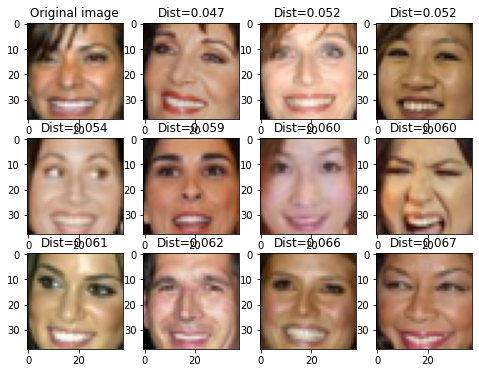

In [42]:
#smiles
show_similar(X_test_tensor[2])

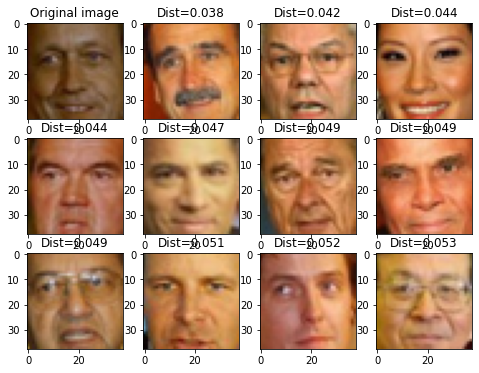

In [43]:
#ethnicity
show_similar(X_test_tensor[500])

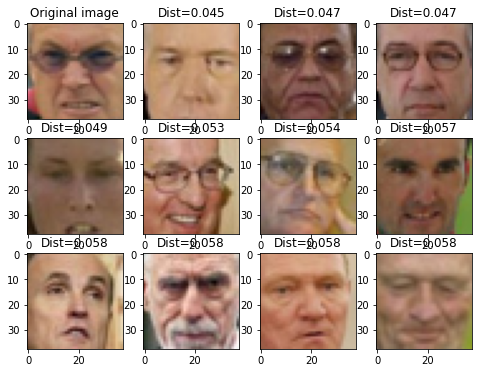

In [44]:
#glasses
show_similar(X_test_tensor[66])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[[-0.0654,  0.3926, -0.2307, -0.8697, -0.9831,  0.4273, -0.8371,
          -0.3329,  0.3874, -0.5731, -0.6257,  0.1663, -0.6969,  0.6628,
           0.1577,  0.9125,  0.8138, -0.4946, -0.1797, -0.4317, -0.5598,
          -0.1714,  0.2824,  0.6391, -0.6284,  0.0523, -0.4108, -0.3526,
          -0.5679,  0.0187,  0.5624, -0.4762]]], device='cuda:0',
       dtype=torch.float64)


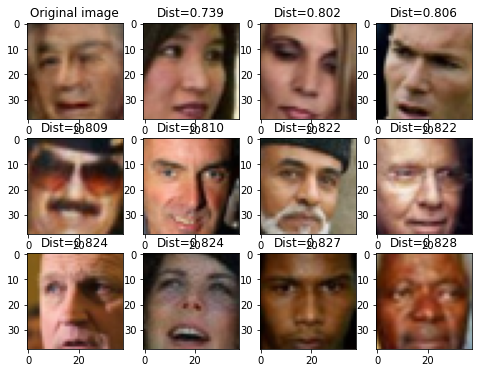

In [117]:
random_latent = torch.randn(32).uniform_(-1, 1).double().unsqueeze(0).to(device)
print(random_latent.unsqueeze(0))
random_image = aenc.dec(random_latent)

show_similar(torch.from_numpy(random_image[0].detach().cpu().numpy()))

In [83]:

a = aenc.enc(X_test_tensor[66].cuda(device)).detach().cpu().numpy()
aenc.dec(a).double().to(device))

SyntaxError: ignored

## Bonus: cheap image morphing


In [69]:
image1,image2 = X_test[np.random.randint(0,len(X_test),size=2)]
a = np.stack([image1,image2])
a.shape

(2, 3, 38, 38)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


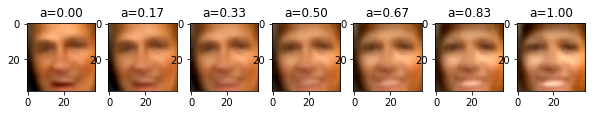

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


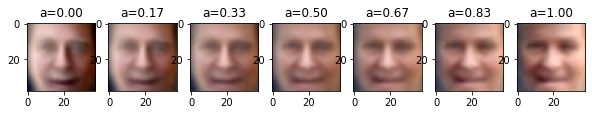

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


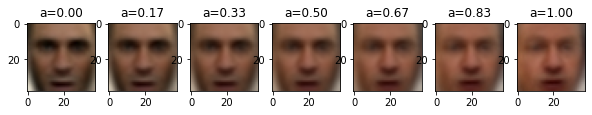

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


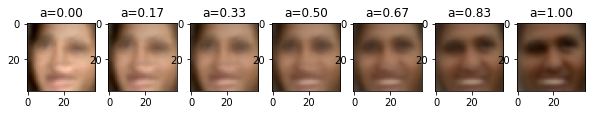

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


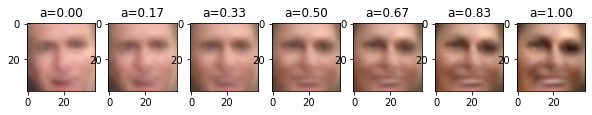

In [71]:

for _ in range(5):
    image1,image2 = X_test_tensor[np.random.randint(0,len(X_test),size=2)]

    code1, code2 = aenc.enc(torch.cat((image1,image2), 0).cuda(device))

    plt.figure(figsize=[10,4])
    for i,a in enumerate(np.linspace(0,1,num=7)):

        output_code = code1*(1-a) + code2*(a)
        output_image = aenc.dec(output_code[None])[0]
        plt.subplot(1,7,i+1)
        plt.imshow(output_image.cpu().detach().numpy().transpose([1,2,0]))
        plt.title("a=%.2f"%a)
        
    plt.show()

Of course there's a lot more you can do with autoencoders.

If you want to generate images from scratch, however, we recommend you our honor track seminar about generative adversarial networks.